In [89]:
from dolfin import *
from mshr import *
import matplotlib
#%matplotlib qt
#%matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

#import time

# Problem C.1
The equations:
\begin{align}
\partial_t u(x,t) - \alpha \Delta u(x, t) &= f(x), \qquad (x, t) \in \mathscr{B} \times (0, T], \\
u(x, t) &= 0, \qquad (x, t) \in \partial \mathscr{B} \times (0, T], \\
u(x, 0) &= \begin{cases}
      \rho, & x \in \mathscr{T},\\
        0,    & x \in \mathscr{B} \setminus \mathscr{T},
    \end{cases} \qquad x \in \mathscr{B}
\end{align}

$\alpha$ is the diffusion coefficient and $\alpha = 0.01mm^2/day$. $f(x)$ is a given source function. $\mathscr{B}:={x \in \mathbb{R}^d: ||x|| \leq 1}$ is a unit disk (in the 2D case) of radius $1$ located at the origin of the space. The boundary $\partial \mathscr{B} = {x \in \mathbb{R}^d: ||x||=1}$. 

$\mathscr{T}$ denotes the torus with the major radius R and the minor radius r, r<R. The the 2D case:
$$ \mathscr{T} := 
(R-(x_1^2 + x_2^2)^\frac{1}{2})^2 + x_3^2 \leq r^2, x \in \mathbb{R}^3 $$

In [79]:
T = 20 # final time  # Pick 20
num_steps = 40 # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
# mesh2D = Mesh('circle3.xml')       #2D case
# V = FunctionSpace(mesh2D, 'CG', 1)
mesh3D = Mesh('sphere2.xml')        #3D case
V = FunctionSpace(mesh3D, 'CG', 1)


# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
R = 0.5
r = 0.2
rho = 10
u_0 = Expression('pow((R-sqrt(x[0]*x[0]+x[1]*x[1])),2)+x[2]*x[2]<=r*r ? rho:0', degree=1, R=R, r=r, rho=rho)  #3D case
# u_0 = Expression('abs(R-sqrt(x[0]*x[0]+x[1]*x[1]))<=r ? rho:0', degree=1, R=R, r=r, rho=rho)  #2D case
u_n = interpolate(u_0, V)
# plot(u_n)
# u_initial2D = u_n.copy()    # for 2D plot

# Define variational problem
alpha = 0.01
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)
F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Mass loss
# Copy initial data
u_initial = Function(V)
u_initial = interpolate(u_0, V)


# Create VTK file for saving solution
# vtkfile = File('3D_sol/solution.pvd')

# Time-stepping
u = Function(V)
t = 0
u_n.rename('u', 'u_n')
# vtkfile << (u_n, t)

mass = []
for n in range(num_steps):
    # Update current time
    t += dt
    
    # Compute solution
    solve(a == L, u, bc)
    M = (u_initial - u) * dx
    mass.append(assemble(M))
    
    # Save to file and plot solution
    u.rename("u", "u")
#     vtkfile << (u, t)
    
    # Update previous solution
    u_n.assign(u)

# u_2D = u.copy()      # Saving the 2D solution for the plot

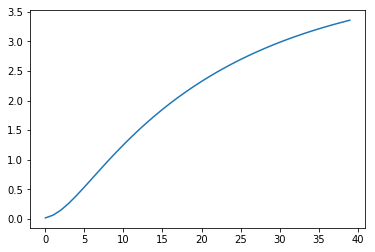

In [80]:
plt.plot(mass)

## Plot for the 2D case

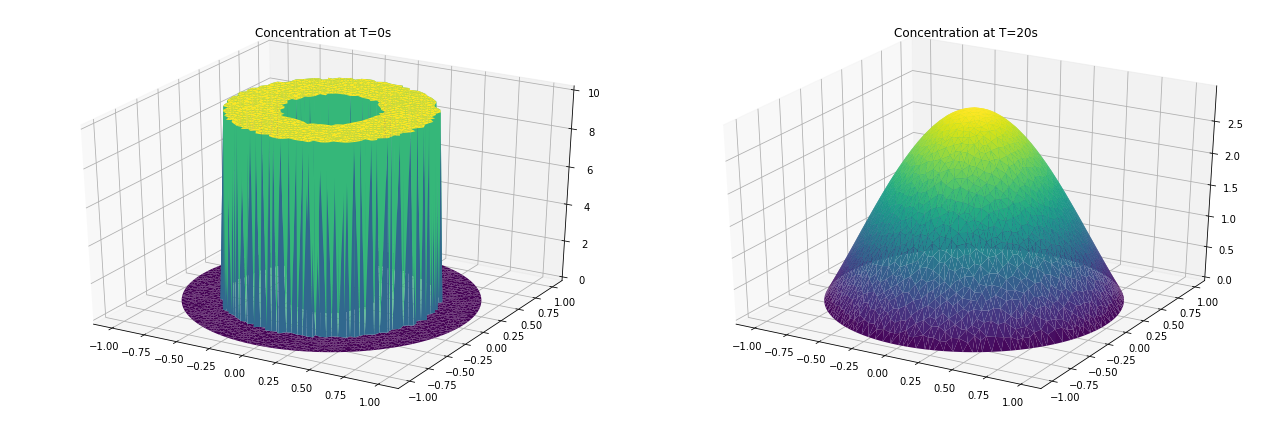

In [45]:
# (x,y) coordinates
V = FunctionSpace(mesh2D, 'CG', 1)    
p = mesh2D.coordinates()   # vertices
x = p[:,0]
y = p[:,1]

# Initial condition
u_0 = Expression('abs(R-sqrt(x[0]*x[0]+x[1]*x[1]))<=r ? rho:0', degree=1, R=R, r=r, rho=rho)
u_initial = interpolate(u_0, V)
u0 = u_initial.compute_vertex_values(mesh2D)

# Plot initial and end condition
fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(x, y, u0, cmap='viridis')
ax.set_title('Concentration at T=0s')
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_trisurf(x, y, uh, cmap='viridis')
ax.set_title('Concentration at T=20s')
plt.savefig('imgs/Fenicsk05_2D.png')

plt.tight_layout()
plt.show()

# Problem C.2

In [83]:
def solution3d(rho, R, r, T):    
    dt = 0.5
    num_steps = int(T/dt) # number of time steps

    # Create mesh and define function space
    mesh3D = Mesh('sphere2.xml')        #3D case
    V = FunctionSpace(mesh3D, 'CG', 1)


    # Define boundary condition
    def boundary(x, on_boundary):
        return on_boundary
    bc = DirichletBC(V, Constant(0), boundary)

    # Define initial value
    u_0 = Expression('pow((R-sqrt(x[0]*x[0]+x[1]*x[1])),2)+x[2]*x[2]<=r*r ? rho:0', degree=1, R=R, r=r, rho=rho)  #3D case
    u_n = interpolate(u_0, V)

    # Define variational problem
    alpha = 0.01
    u = TrialFunction(V)
    v = TestFunction(V)
    f = Constant(0)
    F = u*v*dx + dt*alpha*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
    a, L = lhs(F), rhs(F)

    # Mass loss
    # Copy initial data
    u_initial = Function(V)
    u_initial = interpolate(u_0, V)

    # Create VTK file for saving solution
    # vtkfile = File('3D_sol/solution.pvd')

    # Time-stepping
    u = Function(V)
    t = 0
    # u_n.rename('u', 'u_n')
    # vtkfile << (u_n, t)

    mass = []
    for n in range(num_steps):
        # Update current time
        t += dt

        # Compute solution
        solve(a == L, u, bc)
        M = (u_initial - u) * dx
        mass.append(assemble(M))

        # Save to file and plot solution
        u.rename("u", "u")
    #     vtkfile << (u, t)

        # Update previous solution
        u_n.assign(u)
    
    return mass

## Mass loss for different parameter $\rho$ 

In [94]:
mass1 = solution3d(10, 0.5, 0.2, 50)
mass2 = solution3d(20, 0.5, 0.2, 50)
mass3 = solution3d(40, 0.5, 0.2, 50)

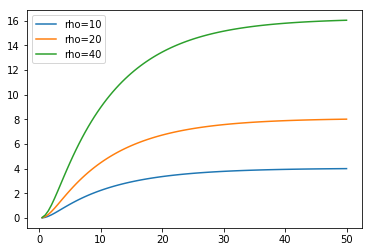

In [104]:
t = np.arange(0.5,50.5,0.5)
plt.plot(t, mass1, label='rho=10')
plt.plot(t, mass2, label='rho=20')
plt.plot(t, mass3, label='rho=40')
plt.legend()
plt.show()

Obviously when $\rho$ is the greatest amongst the three values, it gives the fastes mass loss. It makes sense because diffusion is proportional to the gradient of concentration. The higher the concentration in the torus, the faster the diffusion speed.

# Problem C.3